# A data stack-in-a-box to analyze MTA data with DuckDB

In [2]:
from datetime import date, timedelta
from time import strftime
from os import listdir, system
import pickle
import requests
from pathlib import Path
 
import pandas as pd
# modin uses multithreading but doesn't play well with sql magic
# import modin.pandas as pd

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px

import sqlalchemy

import duckdb

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql
# directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

pd.options.display.max_rows=100

# Connect ipython-sql to DuckDB using a SQLAlchemy-style connection string. You may either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///mta.db

# import qgrid
# from qgrid import show_grid

print(f"pandas               {pd.__version__:<20}")
print(f"seaborn              {sns.__version__:<20}")
print(f"matplotlib           {matplotlib.__version__:<20}")
# print(f"qgrid                {qgrid.__version__:<20}")
print(f"requests             {requests.__version__:<20}")
print(f"sqlalchemy           {sqlalchemy.__version__:<20}")
print(f"duckdb               {duckdb.__version__:<20}")


pandas               1.3.4               
seaborn              0.11.2              
matplotlib           3.5.2               
requests             2.24.0              
sqlalchemy           1.4.45              
duckdb               0.6.1               


- [Data overview](https://data.ny.gov/api/views/py8k-a8wg/files/535bc30e-4119-4992-a799-65d1a05849d4?download=true&filename=MTA_Turnstile_Data_Overview.pdf)
- [Data dictionary](https://data.ny.gov/api/views/py8k-a8wg/files/5c602688-3031-4f39-8f2b-d4a3cd8c3752?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf)
- [List of stations](http://web.mta.info/developers/data/nyct/subway/Stations.csv)
- [Alt station list](https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv)
- [Things to watch out for while working with the MTA turnstile data in 2022](https://towardsai.net/p/l/things-to-watch-out-for-while-working-with-the-mta-turnstile-data-in-2022#:~:text=Additionally%2C%20there%20may%20be%20a,missed%20audit%20that%20was%20recovered.)
- [Taming the MTA's unruly turnstile data](https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0)
- [State Comptroller dashboard](https://www.osc.state.ny.us/reports/osdc/impact-covid-19-pandemic-subway-ridership-new-york-city)
- [Todd Schneider repo](https://github.com/toddwschneider/nyc-subway-turnstile-data)
- [Sonny Ng project](https://www.subwayridership.nyc/)


# Fetch data

In [3]:
# fetch raw data files
# for any missing saturday after start_date and before today
    
downloaddir = "downloads"
csvdir = "csv"
prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
suffix = ".txt"
start_date = date(2019, 1, 7) # start with 1st full week of 2019
end_date = date.today()
delta = end_date - start_date   # returns timedelta

alldays = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
alldays = [day for day in alldays if day.weekday() == 5]

for d in alldays:
    inix=strftime("%y%m%d", d.timetuple())
    url = "%s%s%s" % (prefix, inix, suffix)
    src = "%s/%s%s" % (downloaddir, inix, suffix)
    
    if Path(src).is_file():
        continue
    
    cmd = "curl %s > %s" % (url, src)
    print(cmd)
    system(cmd)
    


In [4]:
datadir = "downloads"
datafiles = sorted(["downloads/" + f for f in listdir(datadir) if f[-4:]==".txt"])
print(len(datafiles))
print(datafiles[:3])
print(datafiles[-3:])


212
['downloads/190105.txt', 'downloads/190112.txt', 'downloads/190119.txt']
['downloads/230107.txt', 'downloads/230114.txt', 'downloads/230121.txt']


In [5]:
# count the lines
!wc -l downloads/*.txt

  201604 downloads/190105.txt
  201091 downloads/190112.txt
  204728 downloads/190119.txt
  201600 downloads/190126.txt
  202913 downloads/190202.txt
  202736 downloads/190209.txt
  204738 downloads/190216.txt
  204056 downloads/190223.txt
  203190 downloads/190302.txt
  203988 downloads/190309.txt
  201793 downloads/190316.txt
  202723 downloads/190323.txt
  204596 downloads/190330.txt
  202965 downloads/190406.txt
  204712 downloads/190413.txt
  202548 downloads/190420.txt
  203858 downloads/190427.txt
  206858 downloads/190504.txt
  204089 downloads/190511.txt
  208682 downloads/190518.txt
  203364 downloads/190525.txt
  203796 downloads/190601.txt
  205012 downloads/190608.txt
  204935 downloads/190615.txt
  207478 downloads/190622.txt
  205964 downloads/190629.txt
  209539 downloads/190706.txt
  208798 downloads/190713.txt
  209007 downloads/190720.txt
  206531 downloads/190727.txt
  206997 downloads/190803.txt
  205876 downloads/190810.txt
  208567 downloads/190817.txt
  205670 d

# Ingest & initial cleanup with DuckDB

In [6]:
# load into mta.db
print ("%s Starting DuckDB initial load" % (strftime("%H:%M:%S")))

17:51:14 Starting DuckDB initial load


In [7]:
%%sql

drop table if exists mta;
drop table if exists temp_data;

create table temp_data(
    "C/A" VARCHAR, 
    UNIT VARCHAR, 
    SCP VARCHAR, 
    STATION VARCHAR, 
    LINENAME VARCHAR, 
    DIVISION VARCHAR, 
    DATE DATE, 
    TIME TIME, 
    "DESC" VARCHAR, 
    ENTRY_COUNTER INTEGER, 
    EXIT_COUNTER INTEGER);


""


In [8]:
datadir = "downloads"
datafiles = sorted([datadir + "/" + f for f in listdir(datadir) if f[-4:]==".txt"])

for f in datafiles:
    print ("%s Loading %s" % (strftime("%H:%M:%S"), f))
    %sql insert into temp_data SELECT * FROM read_csv(:f, \
                                                      delim=',', \
                                                      header=True, \
                                                      columns={'C/A': 'VARCHAR', \
                                                               'UNIT': 'VARCHAR', \
                                                               'SCP': 'VARCHAR', \
                                                               'STATION': 'VARCHAR', \
                                                               'LINENAME': 'VARCHAR', \
                                                               'DIVISION': 'VARCHAR', \
                                                               'DATE': 'DATE', \
                                                               'TIME': 'TIME',\
                                                               'DESC': 'VARCHAR',\
                                                               'ENTRIES': 'INTEGER',\
                                                               'EXITS': 'INTEGER',},\
                                                      dateformat='%m/%d/%Y');
    
    

17:51:14 Loading downloads/190105.txt
17:51:15 Loading downloads/190112.txt
17:51:15 Loading downloads/190119.txt
17:51:15 Loading downloads/190126.txt
17:51:16 Loading downloads/190202.txt
17:51:16 Loading downloads/190209.txt
17:51:17 Loading downloads/190216.txt
17:51:17 Loading downloads/190223.txt
17:51:18 Loading downloads/190302.txt
17:51:18 Loading downloads/190309.txt
17:51:19 Loading downloads/190316.txt
17:51:19 Loading downloads/190323.txt
17:51:19 Loading downloads/190330.txt
17:51:20 Loading downloads/190406.txt
17:51:20 Loading downloads/190413.txt
17:51:21 Loading downloads/190420.txt
17:51:21 Loading downloads/190427.txt
17:51:22 Loading downloads/190504.txt
17:51:22 Loading downloads/190511.txt
17:51:22 Loading downloads/190518.txt
17:51:23 Loading downloads/190525.txt
17:51:23 Loading downloads/190601.txt
17:51:24 Loading downloads/190608.txt
17:51:24 Loading downloads/190615.txt
17:51:25 Loading downloads/190622.txt
17:51:25 Loading downloads/190629.txt
17:51:26 Loa

In [9]:
# 1 header row in each file
# subtract number of files from number of lines found by wc above, should equal this number

%sql SELECT COUNT(*) FROM temp_data


,count_star()
0,44197368


In [10]:
%%sql
select * from temp_data limit 10;

""


In [11]:
# deduplicate rows
%sql create table mta as SELECT distinct * FROM "temp_data" ;
%sql drop table temp_data;
%sql SELECT COUNT(*) FROM mta


,count_star()
0,43986436


In [12]:
# remove these audit records ... might need to check if they should always be deleted
%sql delete from mta where "DESC" = 'RECOVR AUD';
%sql SELECT COUNT(*) FROM mta


,count_star()
0,43788356


In [13]:
# add timestamp from date/time
%sql alter table mta add column DATE_TIME timestamp;
%sql update mta set DATE_TIME = make_timestamp(date_part('year', date), date_part('month', date), date_part('day', date),date_part('hour', TIME), date_part('minute', TIME), date_part('second', TIME))



,Count
0,43788356


In [14]:
# make unique turnstile labels
%sql alter table mta add column TURNSTILE VARCHAR;
%sql update mta set TURNSTILE = CONCAT("C/A" , ' ' , UNIT , ' ' , SCP)


,Count
0,43788356


In [15]:
# make unique station names, else you have '7 AV' in Manhattan, Brooklyn, multiple "23 St" etc
%sql update mta set station = concat(station, '-', linename);


""


In [16]:
# fix some issues with same station having multiple names
# in ideal world would cross-reference MTA station list
fixes = {
    '14 ST-UNION SQ-LNQR456W': '14 ST-UNION SQ-456LNQRW',
    '161/YANKEE STAD-BD4': '161/YANKEE STAD-4BD',
    '34 ST-PENN STA-123': '34 ST-PENN STA-123ACE',
    '34 ST-PENN STA-ACE': '34 ST-PENN STA-123ACE',
    '42 ST-PORT AUTH-ACENGRS1237W': '42 ST-PORT AUTH-ACENQRS1237W',
    '59 ST-NQR456W': '59 ST-456NQRW',
    '59 ST-NRW': '59 ST-456NQRW',
    '59 ST COLUMBUS-ABCD1': '59 ST COLUMBUS-1ABCD',
    'ATL AV-BARCLAY-BDNQR2345': 'ATL AV-BARCLAY-2345BDNQR',
    'BOROUGH HALL-R2345': 'BOROUGH HALL-2345R',
    'COURT SQ-23 ST-EMG': 'COURT SQ-EMG',
    'FULTON ST-ACJZ2345': 'FULTON ST-2345ACJZ',
    'GUN HILL RD-5': 'GUN HILL RD-25',
    'PATH WTC 2-PTH-1': 'PATH NEW WTC-PTH-1',
    'PELHAM PKWY-5': 'PELHAM PKWY-25',
}


for k, v in fixes.items():
    print(k, '->', v)
    %sql update mta set station = :v where station = :k;


14 ST-UNION SQ-LNQR456W -> 14 ST-UNION SQ-456LNQRW
161/YANKEE STAD-BD4 -> 161/YANKEE STAD-4BD
34 ST-PENN STA-123 -> 34 ST-PENN STA-123ACE
34 ST-PENN STA-ACE -> 34 ST-PENN STA-123ACE
42 ST-PORT AUTH-ACENGRS1237W -> 42 ST-PORT AUTH-ACENQRS1237W
59 ST-NQR456W -> 59 ST-456NQRW
59 ST-NRW -> 59 ST-456NQRW
59 ST COLUMBUS-ABCD1 -> 59 ST COLUMBUS-1ABCD
ATL AV-BARCLAY-BDNQR2345 -> ATL AV-BARCLAY-2345BDNQR
BOROUGH HALL-R2345 -> BOROUGH HALL-2345R
COURT SQ-23 ST-EMG -> COURT SQ-EMG
FULTON ST-ACJZ2345 -> FULTON ST-2345ACJZ
GUN HILL RD-5 -> GUN HILL RD-25
PATH WTC 2-PTH-1 -> PATH NEW WTC-PTH-1
PELHAM PKWY-5 -> PELHAM PKWY-25


In [17]:
%sql SELECT station, count(*) FROM mta group by station order by station;


""


In [18]:
# not sure why %sql magic sometimes doesn't display table here  
con = duckdb.connect('mta.db')
query = "SELECT station, count(*) FROM mta group by station order by station;"
con.execute(query)
con.fetchall()


[('1 AV-L', 170589),
 ('103 ST-1', 53285),
 ('103 ST-6', 54196),
 ('103 ST-BC', 26857),
 ('103 ST-CORONA-7', 79976),
 ('104 ST-A', 44282),
 ('104 ST-JZ', 35502),
 ('110 ST-6', 53342),
 ('111 ST-7', 44278),
 ('111 ST-A', 60850),
 ('111 ST-J', 31762),
 ('116 ST-23', 70322),
 ('116 ST-6', 70903),
 ('116 ST-BC', 53082),
 ('116 ST-COLUMBIA-1', 53036),
 ('121 ST-JZ', 52980),
 ('125 ST-1', 44221),
 ('125 ST-23', 70815),
 ('125 ST-456', 123652),
 ('125 ST-ACBD', 140920),
 ('135 ST-23', 105986),
 ('135 ST-BC', 96616),
 ('137 ST CITY COL-1', 88566),
 ('138/GRAND CONC-45', 26472),
 ('14 ST-123FLM', 133470),
 ('14 ST-ACEL', 117796),
 ('14 ST-FLM123', 191326),
 ('14 ST-UNION SQ-456LNQRW', 361860),
 ('145 ST-1', 61593),
 ('145 ST-3', 35149),
 ('145 ST-ABCD', 79134),
 ('149/GRAND CONC-245', 61597),
 ('14TH STREET-1', 90546),
 ('15 ST-PROSPECT-FG', 106212),
 ('155 ST-BD', 26640),
 ('155 ST-C', 44431),
 ('157 ST-1', 70726),
 ('161/YANKEE STAD-4BD', 323586),
 ('163 ST-AMSTERDM-C', 70938),
 ('167 ST-4', 

In [19]:
%%sql
ALTER TABLE mta DROP LINENAME;
ALTER TABLE mta DROP DIVISION;
ALTER TABLE mta DROP "DESC";
ALTER TABLE mta DROP TIME;
ALTER TABLE mta DROP "C/A";
ALTER TABLE mta DROP UNIT;
ALTER TABLE mta DROP SCP;


""


In [20]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,STATION,VARCHAR,YES,None,None,None
1,DATE,DATE,YES,None,None,None
2,ENTRY_COUNTER,INTEGER,YES,None,None,None
3,EXIT_COUNTER,INTEGER,YES,None,None,None
4,DATE_TIME,TIMESTAMP,YES,None,None,None
5,TURNSTILE,VARCHAR,YES,None,None,None


In [21]:
%%sql
PRAGMA database_size;

""


In [22]:
# query = "PRAGMA database_size;"
# con.execute(query)
# con.fetchall()


In [23]:
print ("%s Ending DuckDB initial load" % (strftime("%H:%M:%S")))


18:09:00 Ending DuckDB initial load


# Data quality with DuckDB

- check if each turnstile is available for each station for each time, compute % time coverage vs. expected
- check any overlapping time periods by turnstile 
- compute change in entries, exits by turnstile by time
- fix negatives
- fix outliers, usually indicate maintenance reset count 

Should review articles and Todd Schneider code for additional data quality checks and fixes. Could possibly add better data quality with

- https://greatexpectations.io/
- https://pandera.readthedocs.io/en/stable/
- https://github.com/awslabs/python-deequ
    

## Compute diffs

In [24]:
print ("%s Starting diff and DQ" % (strftime("%H:%M:%S")))


18:09:00 Starting diff and DQ


In [25]:
%%sql
drop table if exists mta_diff;

CREATE TABLE mta_diff AS 
SELECT DATE, DATE_TIME, STATION, TURNSTILE, 
ENTRY_COUNTER,
ENTRY_COUNTER - lag(ENTRY_COUNTER) OVER (PARTITION BY STATION, TURNSTILE ORDER BY DATE_TIME) AS ENTRIES,
2000 ENTRIES_CUTOFF ,
EXIT_COUNTER,
EXIT_COUNTER - lag(EXIT_COUNTER) OVER (PARTITION BY STATION, TURNSTILE ORDER BY DATE_TIME) AS EXITS,
2000 EXITS_CUTOFF
FROM mta;


""


In [26]:
%sql describe mta_diff;

""


In [27]:
%sql select * from mta_diff order by station, turnstile, date_time limit 100;

""


In [28]:
%sql drop table mta;

""


In [29]:
%sql ALTER TABLE mta_diff drop column ENTRY_COUNTER;
%sql ALTER TABLE mta_diff drop column EXIT_COUNTER;
%sql ALTER TABLE mta_diff RENAME TO mta;


""


In [30]:
# browse mta
# qgrid gives a sortable table but seems to have compatibility issues
%sql df << SELECT * FROM mta where station ='ORCHARD BEACH-6'
# show_grid(df)

Returning data to local variable df


In [31]:
df

,DATE,DATE_TIME,STATION,TURNSTILE,ENTRIES,ENTRIES_CUTOFF,EXITS,EXITS_CUTOFF
0,2019-05-22,2019-05-22 16:00:00,ORCHARD BEACH-6,OB01 R459 00-00-01,NaN,2000,NaN,2000
1,2019-05-22,2019-05-22 20:00:00,ORCHARD BEACH-6,OB01 R459 00-00-01,0.0,2000,0.0,2000
2,2019-05-23,2019-05-23 00:00:00,ORCHARD BEACH-6,OB01 R459 00-00-01,0.0,2000,0.0,2000
3,2019-05-23,2019-05-23 04:00:00,ORCHARD BEACH-6,OB01 R459 00-00-01,0.0,2000,0.0,2000
4,2019-05-23,2019-05-23 08:00:00,ORCHARD BEACH-6,OB01 R459 00-00-01,0.0,2000,0.0,2000
...,...,...,...,...,...,...,...,...
13977,2022-09-27,2022-09-27 16:00:00,ORCHARD BEACH-6,OB01 R459 00-00-02,0.0,2000,0.0,2000
13978,2022-09-27,2022-09-27 20:00:00,ORCHARD BEACH-6,OB01 R459 00-00-02,0.0,2000,0.0,2000
13979,2022-09-28,2022-09-28 00:00:00,ORCHARD BEACH-6,OB01 R459 00-00-02,0.0,2000,0.0,2000
13980,2022-09-28,2022-09-28 04:00:00,ORCHARD BEACH-6,OB01 R459 00-00-02,0.0,2000,0.0,2000


## Check for dupes

In [32]:
%%sql 

select DATE_TIME, STATION, TURNSTILE, count(*) from mta
group by DATE_TIME, STATION, TURNSTILE
having count(*) > 1;


""


## fix <=0, sometimes maintenance is done, resets turnstile counter


In [33]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,DATE,DATE,YES,None,None,None
1,DATE_TIME,TIMESTAMP,YES,None,None,None
2,STATION,VARCHAR,YES,None,None,None
3,TURNSTILE,VARCHAR,YES,None,None,None
4,ENTRIES,INTEGER,YES,None,None,None
5,ENTRIES_CUTOFF,INTEGER,YES,None,None,None
6,EXITS,INTEGER,YES,None,None,None
7,EXITS_CUTOFF,INTEGER,YES,None,None,None


In [34]:
# delete rows at start of window with no diff

In [35]:
%%sql
delete from mta
where entries is null 
and exits is null;


""


In [36]:
%%sql
select count(*) from mta where ENTRIES < 0;


""


In [37]:
%%sql
select count(*) from mta where EXITS < 0;


""


In [38]:
%%sql
delete from mta where ENTRIES < 0;


""


In [39]:
%%sql
delete from mta where EXITS < 0;


""


## Dropping bad rows

- Taking a slightly more permissive approach than cutting off everything > 2K
- Looking at e.g. BEDFORD AV-L	H009	R235	00-03-04 , does 2000 on the regular
- First cut off everything > 6K. Every 2s = 7200 in 4h period. but I wonder if sometimes the period is longer? I could see a deal at a massive event where trains keep coming and there is always a queue at a turnstile
- Then compute average, sd, count by turnstile
- if count < 20 then cut off everything > 2K
- if count >= 20 then cut off everything based on SD, with a 1K minmimum threshold
- Seems to call for some kind of bayesian approach, maybe use one of the DQ packages
    - for each new turnstile start with a prior distribution on the turnstile mean and sd based on all the turnstiles
    - for each observation at that turnstile, update the prior
    - at the end , discard the observations that are eg 4 updated sds from the updated mean. (we should think about what sort of true distribution there is, how many we will discard, what the tradeoff is for rejecting a row incorrectly).
    - so if you only have 1 observation, you'll be discarding based on close to the population mean and sd
    - if you have 30 observations, you'll be discarding based on close to the turnstile mean and sd
    - also if there was turnstile maintenance both entries and exits should be off, can add signal and reduce sd threshold and require both to be off (not doing this)
     - IMO it's pretty easy for something weird to happen where something goes to a different mode, flood or cops or something closes an entrance, 1-time big event. Seems like a good DQ framework needs a flexible rule plus some whitelisted days/exceptions.

## Hard 7200 limit per turnstile per period


In [40]:
%%sql
select count(*) from mta where ENTRIES > 7200;


""


In [41]:
%%sql
select count(*) from mta where EXITS > 7200;


""


In [42]:
%%sql
delete from mta where ENTRIES>7200;
delete from mta where EXITS>7200;


""


## Compute average, sd, observation count by turnstile

In [43]:
%%sql 
drop table if exists entry_avg;
create table entry_avg as 
select station, TURNSTILE, avg(entries) MEAN, stddev(entries) SD, count(*) N, 
from mta
where entries > 0
group by station, TURNSTILE;


""


In [44]:
%%sql 
select * from entry_avg order by MEAN desc limit 100;

""


In [45]:
%%sql
select * from entry_avg where turnstile ='N078 R175 01-06-00'
limit 100;

""


In [46]:
%%sql
select * from mta
where turnstile ='N078 R175 01-06-00'
order by entries desc limit 100;

""


In [47]:
%%sql
alter table entry_avg add column ENTRIES_CUTOFF DOUBLE;
update entry_avg set ENTRIES_CUTOFF = MEAN + 3 * SD;
update entry_avg set ENTRIES_CUTOFF = 2000 where N <= 20;
update entry_avg set ENTRIES_CUTOFF = 2000 where ENTRIES_CUTOFF > 100000;
update entry_avg set ENTRIES_CUTOFF = 2000 where isnan(ENTRIES_CUTOFF);
update entry_avg set ENTRIES_CUTOFF = 2000 where ENTRIES_CUTOFF < 2000;


""


In [48]:
%%sql
update mta 
set ENTRIES_CUTOFF = (
select ENTRIES_CUTOFF from entry_avg
    where
    entry_avg.station = mta.station and 
    entry_avg.turnstile = mta.turnstile
)
where exists (
    select 1 from entry_avg
    where
    entry_avg.station = mta.station and 
    entry_avg.turnstile = mta.turnstile
)




,Count
0,41258213


In [49]:
%%sql 
drop table if exists exit_avg;
create table exit_avg as 
select station, TURNSTILE, avg(exits) MEAN, stddev(exits) SD, count(*) N, 
from mta
where exits > 0
group by station, TURNSTILE;


""


In [50]:
%%sql
select * from exit_avg order by MEAN desc limit 100;


""


In [51]:
%%sql
select * from mta where turnstile='N012 R035 01-05-01'
order by exits desc limit 100;

""


In [52]:
%%sql
alter table exit_avg add column EXITS_CUTOFF DOUBLE;
update exit_avg set EXITS_CUTOFF = MEAN + 3 * SD;
update exit_avg set EXITS_CUTOFF = 2000 where N <= 20;
update exit_avg set EXITS_CUTOFF = 2000 where EXITS_CUTOFF > 100000;
update exit_avg set EXITS_CUTOFF = 2000 where isnan(EXITS_CUTOFF);
update exit_avg set EXITS_CUTOFF = 2000 where EXITS_CUTOFF < 2000;


""


In [53]:
%%sql
update mta
set EXITS_CUTOFF = (
select EXITS_CUTOFF from exit_avg
    where
    exit_avg.station = mta.station and 
    exit_avg.turnstile = mta.turnstile 
)
where exists (
    select 1 from exit_avg
    where
    exit_avg.station = mta.station and 
    exit_avg.turnstile = mta.turnstile
)


,Count
0,41235447


In [54]:
print ("%s deleting based on cutoff" % (strftime("%H:%M:%S")))


18:11:04 deleting based on cutoff


In [55]:
# hard cutoff, delete if either exits or entries exceeds. 
# although if a technical issue both entries and exits should be off

In [56]:
%%sql 
delete from mta where entries > entries_cutoff


,Count
0,11657


In [57]:
%%sql
delete from mta where exits > exits_cutoff


,Count
0,16134


In [58]:
%%sql
delete from mta where entries=0 and exits=0;


""


In [59]:
print ("%s Finishing diff and DQ" % (strftime("%H:%M:%S")))


18:14:57 Finishing diff and DQ


In [60]:
%%sql
select count(*) from mta

,count_star()
0,37854622


In [61]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,DATE,DATE,YES,None,None,None
1,DATE_TIME,TIMESTAMP,YES,None,None,None
2,STATION,VARCHAR,YES,None,None,None
3,TURNSTILE,VARCHAR,YES,None,None,None
4,ENTRIES,INTEGER,YES,None,None,None
5,ENTRIES_CUTOFF,INTEGER,YES,None,None,None
6,EXITS,INTEGER,YES,None,None,None
7,EXITS_CUTOFF,INTEGER,YES,None,None,None


In [62]:
%%sql
PRAGMA database_size;


""


# Aggregate and visualize

In [94]:
print ("%s Starting aggregation and dataviz" % (strftime("%H:%M:%S")))


21:11:53 Starting aggregation and dataviz


In [95]:
%%sql

df << select DATE, sum(ENTRIES) ENTRIES
from mta
group by date
order by date;

Returning data to local variable df


In [96]:
con.execute("""
select DATE, sum(ENTRIES) ENTRIES from mta
group by DATE
order by DATE
""")
df = pd.DataFrame(con.fetchall(), columns=['DATE', 'ENTRIES'])
df

,DATE,ENTRIES
0,2018-12-29,3053834
1,2018-12-30,2801130
2,2018-12-31,3668315
3,2019-01-01,2315896
4,2019-01-02,5153319
...,...,...
1472,2023-01-16,1355084
1473,2023-01-17,2257662
1474,2023-01-18,2355907
1475,2023-01-19,2259693


In [97]:

df["rolling"] = df['ENTRIES'].rolling(28).sum()/28/1000000
df


,DATE,ENTRIES,rolling
0,2018-12-29,3053834,NaN
1,2018-12-30,2801130,NaN
2,2018-12-31,3668315,NaN
3,2019-01-01,2315896,NaN
4,2019-01-02,5153319,NaN
...,...,...,...
1472,2023-01-16,1355084,1.737539
1473,2023-01-17,2257662,1.733438
1474,2023-01-18,2355907,1.732763
1475,2023-01-19,2259693,1.736487


In [98]:
fig = px.line(df, x="DATE", y="rolling", title='Entries by day (rolling 28-day average)')
fig.show()


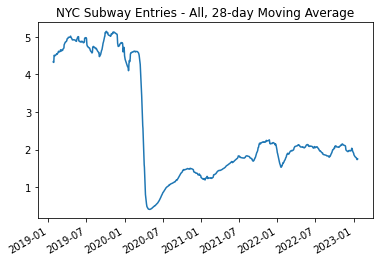

In [99]:
plt.plot(df["DATE"], df["rolling"])
plt.title("NYC Subway Entries - All, 28-day Moving Average")
plt.gcf().autofmt_xdate();


In [100]:
cbd_stations = ['1 AV-L',
'14 ST-123FLM',
'14 ST-ACEL',
'14 ST-UNION SQ-456LNQRW',
'14TH STREET-1',
'18 ST-1',
'2 AV-F',
'23 ST-1',
'23 ST-6',
'23 ST-CE',
'23 ST-FM',
'23 ST-NRW',
'28 ST-1',
'28 ST-6',
'28 ST-NRW',
'3 AV-L',
'33 ST-6',
'34 ST-HERALD SQ-BDFMNQRW',
'34 ST-HUDSON YD-7',
'34 ST-PENN STA-123',
'34 ST-PENN STA-123ACE',
'34 ST-PENN STA-ACE',
'42 ST-BRYANT PK-7BDFM',
'42 ST-PORT AUTH-1237ACEGNRSW',
'42 ST-PORT AUTH-1237ACENQRSW',
'47-50 STS ROCK-BDFM',
'49 ST-NQRW',
'5 AV/53 ST-EM',
'5 AV/59 ST-NQRW',
'5 AVE-7BDFM',
'50 ST-1',
'50 ST-CE',
'50 ST-D',
'51 ST-6',
'57 ST-7 AV-NQRW',
'57 ST-F',
'59 ST COLUMBUS-1ABCD',
'59 ST-456NQRW',
'59 ST-NRW',
'6 AV-123FLM',
'7 AV-BDE',
'8 AV-ACEL',
'8 ST-NYU-NRW',
'9TH STREET-1',
'ASTOR PL-6',
"B'WAY-LAFAYETTE-6BDFQ",
'BLEECKER ST-6DF',
'BOWLING GREEN-45',
'BROAD ST-JZ',
'BROOKLYN BRIDGE-456JZ',
'CANAL ST-1',
'CANAL ST-6JNQRWZ',
'CANAL ST-ACE',
'CHAMBERS ST-123',
'CHAMBERS ST-23ACE',
'CHAMBERS ST-456JZ',
'CHRISTOPHER ST-1',
'CITY HALL-NRW',
'CORTLANDT ST-NRW',
'DELANCEY/ESSEX-FJMZ',
'EAST BROADWAY-F',
'EXCHANGE PLACE-1',
'FRANKLIN ST-1',
'FULTON ST-2345ACJZ',
'GRAND ST-BD',
'GRD CNTRL-42 ST-4567S',
'HOUSTON ST-1',
'LEXINGTON AV/53-6EM',
'LEXINGTON AV/63-F',
'PARK PLACE-23ACE',
'PATH NEW WTC-1',
'PATH WTC 2-1',
'PRINCE ST-NRW',
'RECTOR ST-1',
'RECTOR ST-NRW',
'SOUTH FERRY-1RW',
'SPRING ST-6',
'SPRING ST-CE',
'TIMES SQ-42 ST-1237ACENQRS',
'TIMES SQ-42 ST-1237ACENQRSW',
'TWENTY THIRD ST-1',
'W 4 ST-WASH SQ-ABCDEFM',
'WALL ST-23',
'WALL ST-45',
'WHITEHALL S-FRY-1RW',
'WORLD TRADE CTR-23ACE',
'WTC-CORTLANDT-1',
]


In [101]:
%%sql df << select DATE, STATION, sum(ENTRIES) ENTRIES
from mta
group by DATE, STATION
order by entries desc;

Returning data to local variable df


In [102]:
con.execute("""
select DATE, STATION, sum(ENTRIES) ENTRIES
from mta
group by DATE, STATION
order by entries desc;
""")
df = pd.DataFrame(con.fetchall(), columns=['DATE', 'STATION', 'ENTRIES'])
df

,DATE,STATION,ENTRIES
0,2019-10-03,34 ST-PENN STA-123ACE,184904
1,2019-12-12,34 ST-PENN STA-123ACE,182952
2,2019-12-18,34 ST-PENN STA-123ACE,182520
3,2019-10-25,34 ST-PENN STA-123ACE,181684
4,2019-12-05,34 ST-PENN STA-123ACE,181411
...,...,...,...
683415,2022-06-08,ORCHARD BEACH-6,0
683416,2020-06-03,ORCHARD BEACH-6,0
683417,2019-04-14,79 ST-D,0
683418,2022-09-18,BROAD CHANNEL-AS,0


In [103]:
# manhattan < 66 st
# before 11am on weekday
cbd_df = df.loc[df["STATION"].isin(cbd_stations)].copy()
len(cbd_df)

106292

In [104]:
cbd_df = cbd_df[['DATE', 'ENTRIES']].groupby("DATE") \
    .sum() \
    .reset_index()

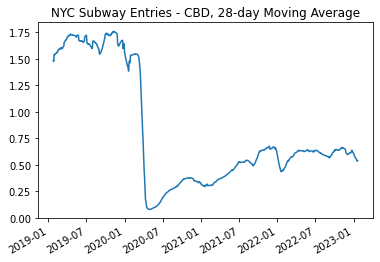

In [105]:
cbd_df["rolling"] = cbd_df['ENTRIES'].rolling(28).sum()/28/1000000

plt.plot(cbd_df["DATE"], cbd_df["rolling"])
plt.title("NYC Subway Entries - CBD, 28-day Moving Average")
plt.gcf().autofmt_xdate();


In [106]:
%%sql
df << select DATE, DATE_TIME, sum(ENTRIES) ENTRIES
from mta
where ENTRIES > 0
group by DATE, DATE_TIME
order by DATE, DATE_TIME;


Returning data to local variable df


In [107]:
con.execute("""
select DATE, DATE_TIME, sum(ENTRIES) ENTRIES from mta group by DATE, DATE_TIME
order by DATE, DATE_TIME
""")
df = pd.DataFrame(con.fetchall(), columns=['DATE', 'DATE_TIME', 'ENTRIES'])


In [108]:
df

,DATE,DATE_TIME,ENTRIES
0,2018-12-29,2018-12-29 04:00:00,33926
1,2018-12-29,2018-12-29 04:12:20,0
2,2018-12-29,2018-12-29 04:14:06,0
3,2018-12-29,2018-12-29 04:15:00,1
4,2018-12-29,2018-12-29 04:16:50,10
...,...,...,...
2493003,2023-01-20,2023-01-20 23:57:31,0
2493004,2023-01-20,2023-01-20 23:57:43,63
2493005,2023-01-20,2023-01-20 23:57:54,0
2493006,2023-01-20,2023-01-20 23:58:33,31


In [109]:
df["weekday"] = df["DATE_TIME"].dt.weekday
df["hour"] = df["DATE_TIME"].dt.hour

morn_df = df.loc[df["weekday"] < 5]
df_am = morn_df.loc[df["hour"] < 12]
df_am

,DATE,DATE_TIME,ENTRIES,weekday,hour
3116,2018-12-31,2018-12-31 00:00:00,125040,0,0
3117,2018-12-31,2018-12-31 00:01:31,16,0,0
3118,2018-12-31,2018-12-31 00:01:55,8,0,0
3119,2018-12-31,2018-12-31 00:01:59,22,0,0
3120,2018-12-31,2018-12-31 00:02:17,37,0,0
...,...,...,...,...,...
2492116,2023-01-20,2023-01-20 11:58:01,18,4,11
2492117,2023-01-20,2023-01-20 11:58:10,71,4,11
2492118,2023-01-20,2023-01-20 11:58:36,5,4,11
2492119,2023-01-20,2023-01-20 11:58:40,45,4,11


In [110]:
agg_ent = df_am[["DATE", "ENTRIES"]] \
    .groupby(["DATE"]) \
    .sum() \
    .reset_index() \
    .copy()

agg_ent["rolling"] = agg_ent['ENTRIES'].rolling(28).sum()/28/1000000
agg_ent

,DATE,ENTRIES,rolling
0,2018-12-31,1025300,NaN
1,2019-01-01,678351,NaN
2,2019-01-02,1575089,NaN
3,2019-01-03,1739774,NaN
4,2019-01-04,1792794,NaN
...,...,...,...
1050,2023-01-16,390309,0.676845
1051,2023-01-17,771268,0.673660
1052,2023-01-18,802476,0.674495
1053,2023-01-19,788889,0.676379


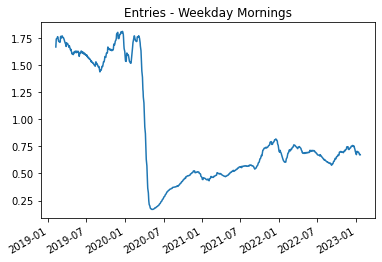

In [111]:
plt.plot(agg_ent["DATE"], agg_ent["rolling"])
plt.title("Entries - Weekday Mornings")
plt.gcf().autofmt_xdate();


In [112]:
print ("%s all done!" % (strftime("%H:%M:%S")))


21:12:02 all done!


In [115]:
con.close()